In [5]:
import scipy
import numpy as np
import h5py
import matplotlib.pyplot as plt
import bubblewrap

# Monkey Reach
[source](https://zenodo.org/record/3854034)

In [6]:
fhan = h5py.File('indy_20160407_02.mat', 'r')

In [8]:
# this is a first pass I'm using to find the first and last spikes
l = []
for j in range(fhan['spikes'].shape[1]):
    for i in range(fhan['spikes'].shape[0]):
        v = np.squeeze(fhan[fhan['spikes'][i,j]])
        if v[0] > 50: # empy channels have one spike very early while everything else is quiet
            l.append(v)

# this finds the first and last spikes in the dataset so we can set our bin boundaries
ll = [leaf for tree in l for leaf in tree]
stop = np.ceil(max(ll))
start = np.floor(min(ll))

# this creates the bins we'll use to group spikes
bin_width = .03 # units are seconds
bins = np.arange(start,stop, bin_width)
bin_centers = np.convolve([.5, .5], bins, "valid")

In [9]:
# columns of A are channels, rows are time bins
A = np.zeros(shape=(bins.shape[0]-1,len(l)))
c = 0 # we need this because some channels are empty
for j in range(fhan['spikes'].shape[1]):
    for i in range(fhan['spikes'].shape[0]):
        v = np.squeeze(fhan[fhan['spikes'][i,j]])
        if v[0] > 50:
            A[:, c],_ =  np.histogram(np.squeeze(fhan[fhan['spikes'][i,j]]), bins=bins)
            c += 1

In [10]:
# load behavior data
raw_behavior = fhan['finger_pos'][:].T
t = fhan["t"][0]

# this resamples the behavior so it's in sync with the binned spikes
behavior = np.zeros((bin_centers.shape[0],raw_behavior.shape[1]))
for c in range(behavior.shape[1]):
    behavior[:,c] = np.interp(bin_centers, t, raw_behavior[:,c])
    

In [11]:
mask = bin_centers > 70 # behavior is near-constant before 70 seconds
bin_centers, behavior, A = bin_centers[mask], behavior[mask], A[mask] 

In [12]:
np.savez("indy_full.npz", y=A[None,:,:], x=behavior)

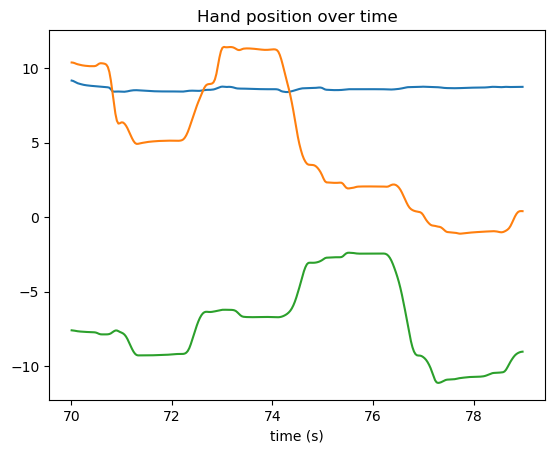

In [18]:
plt.plot(bin_centers[:300], behavior[:300]);
plt.title("Hand position over time");
plt.xlabel("time (s)");

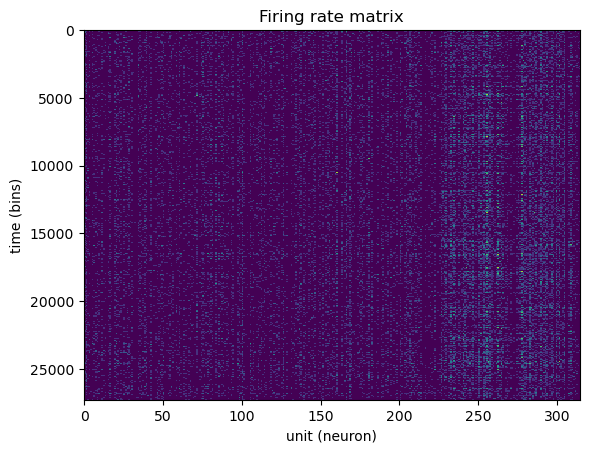

In [21]:
plt.imshow(A, aspect='auto', interpolation='nearest');
plt.title("Firing rate matrix");
plt.ylabel("time (bins)");
plt.xlabel("unit (neuron)");

100%|██| 80/80 [00:00<00:00, 1072.56it/s]


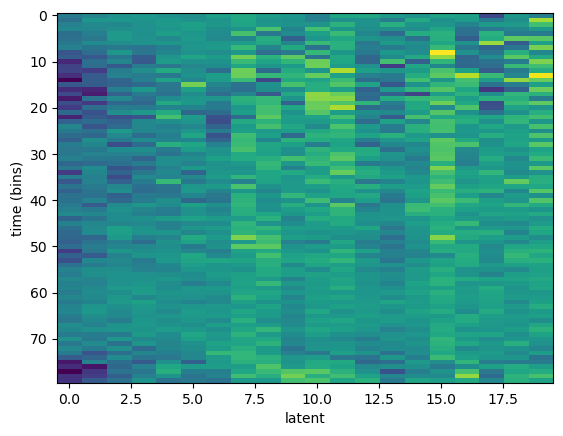

In [23]:
plt.imshow(bubblewrap.input_sources.functional.prosvd_data(A[1100:1200], 20, 20), aspect='auto', interpolation='nearest');
plt.xlabel("latent");
plt.title("");
plt.ylabel("time (bins)");

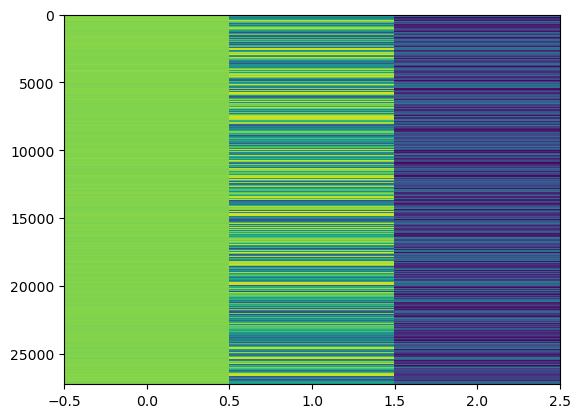

In [14]:
plt.imshow(behavior, aspect='auto', interpolation='nearest')